In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available.')
else:
    print('No GPU is available.')
# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


GPU is available.


In [2]:
import gym_super_mario_bros
from gym.spaces import Box
from gym import Wrapper
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY
import cv2
import numpy as np
import subprocess as sp

""" 
 Contains Monitor class to preorpcess and record
"""
class Monitor:
    def __init__(self, width, height, saved_path):

        self.command = ["ffmpeg", "-y", "-f", "rawvideo", "-vcodec", "rawvideo", "-s", "{}X{}".format(width, height),
                        "-pix_fmt", "rgb24", "-r", "60", "-i", "-", "-an", "-vcodec", "mpeg4", saved_path]
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError:
            pass

    def record(self, image_array):
        try:
            self.pipe = sp.Popen(self.command, stdin=sp.PIPE, stderr=sp.PIPE)
        except FileNotFoundError as e:
            print(f"Error creating Monitor: {e}")



def process_frame(frame):
    if frame is not None:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84))[None, :, :] / 255.
        return frame
    else:
        return np.zeros((1, 84, 84))


class CustomReward(Wrapper):
    def __init__(self, env=None, monitor=None):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(1, 84, 84))
        self.curr_score = 0
        if monitor:
            self.monitor = monitor
        else:
            self.monitor = None

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if self.monitor:
            self.monitor.record(state)
        state = process_frame(state)
        reward += (info["score"] - self.curr_score) / 40.
        self.curr_score = info["score"]
        if done:
            if info["flag_get"]:
                reward += 100
            else:
                reward -= 50
        return state, reward *0.05, done, info

    def reset(self):
        self.curr_score = 0
        return process_frame(self.env.reset())


class CustomSkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super(CustomSkipFrame, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(skip, 84, 84))
        self.skip = skip
        self.states = np.zeros((skip, 84, 84), dtype=np.float32)

    def step(self, action):
        total_reward = 0
        last_states = []
        for i in range(self.skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if i >= self.skip /2:
                last_states.append(state)
            if done:
                self.reset()
                return self.states[None, :, :, :].astype(np.float32), total_reward, done, info
        max_state = np.max(np.concatenate(last_states,0), 0)
        self.states[:-1] = self.states[1:]
        self.states[-1] = max_state
        return self.states[None, :, :, :].astype(np.float32), total_reward, done, info


    def reset(self):
        state = self.env.reset()
        self.states = np.concatenate([state for _ in range(self.skip)], 0)
        return self.states[None, :, :, :].astype(np.float32)


def create_train_env(actions, output_path=None):
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")
    if output_path:
        monitor = Monitor(256, 240, output_path)
    else:
        monitor = None

    env = JoypadSpace(env, actions)
    env = CustomReward(env, monitor)
    env = CustomSkipFrame(env)
    return env


import torch.multiprocessing as mp

class MultipleEnvironments:
    def __init__(self, action_type, num_envs, output_path=None):
        self.agent_conns, self.env_conns = zip(*[mp.Pipe() for _ in range(num_envs)])
        if action_type == "right":
            actions = RIGHT_ONLY
            print("Action Right SET")
        elif action_type == "simple":
            actions = SIMPLE_MOVEMENT
            print("Action Simple Movements SET")
        else:
            actions = COMPLEX_MOVEMENT
            print("Action Complex SET")
        self.envs = [create_train_env(actions, output_path=output_path) for _ in range(num_envs)]
        print("sself env done")
        self.num_states = self.envs[0].observation_space.shape[0]
        print("sefl state done")
        self.num_actions = len(actions)
        print("Action done SET")
            
        for index in range(num_envs):
            print("Action: Startring process")
            process = mp.Process(target=self.run, args=(index,))
            print("Action: process IniI")
            process.start()
            print("Action: process almost done")
            self.env_conns[index].close()
        print("Environments created and processes started.")

    def run(self, index):
        self.agent_conns[index].close()
        while True:
            request, action = self.env_conns[index].recv()
            print(f"Environment {index} received request: {request}")
            if request == "step":
                print(f"Environment {index} is stepping with action: {action.item()}")
                self.env_conns[index].send(self.envs[index].step(action.item()))
            elif request == "reset":
                print(f"Environment {index} is resetting")
                self.env_conns[index].send(self.envs[index].reset())
            else:
                raise NotImplementedError


PPO Model

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, initializers

class PPO(tf.keras.Model):
    def __init__(self, num_inputs, num_actions):
        super(PPO, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=num_inputs)
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.linear = tf.keras.layers.Dense(512, activation='relu')
        self.critic_linear = tf.keras.layers.Dense(1)
        self.actor_linear = tf.keras.layers.Dense(num_actions)
        # No need for _initialize_weights method if using default initializations

    def call(self, inputs):
        x = tf.nn.relu(self.conv1(inputs))
        x = tf.nn.relu(self.conv2(x))
        x = tf.nn.relu(self.conv3(x))
        x = tf.nn.relu(self.conv4(x))
        x = self.flatten(x)
        x = tf.nn.relu(self.linear(x))
        actor_output = self.actor_linear(x)
        critic_output = self.critic_linear(x)
        return actor_output, critic_output

Train processes

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [5]:
# !python -m pip install tensorflow_probability==0.12.2

In [6]:
import warnings

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import timeit
from tensorboardX import SummaryWriter
import numpy as np
import tensorflow_probability as tfp

from collections import deque

In [8]:
# def eval(opt, global_model, num_states, num_actions):
#     tf.random.set_seed(123)
#     if opt.action_type == "right":
#         actions = RIGHT_ONLY
#     elif opt.action_type == "simple":
#         actions = SIMPLE_MOVEMENT
#     else:
#         actions = COMPLEX_MOVEMENT
#     env = create_train_env(actions=actions)
#     local_model = PPO(num_states, num_actions)
#     # local_model.evaluate()
#     state = tf.convert_to_tensor(env.reset())
#     done = True
#     curr_step = 0
#     actions = deque(maxlen=opt.max_actions)
#     while True:
#         curr_step +=1
#         if done:
#             local_model.set_weights(global_model.get_weights())
#             logits, value = local_model(state)
#             policy = tf.nn.softmax(logits, dim=1)
#             action = tf.argmax(policy).item()
#             state, reward, done, info = env.step(action)
#            # Uncomment following lines if you want to save model whenever level is completed
#             if info["flag_get"]:
#                 print("Finished")
#                 local_model.saved_model("{}/ppo_super_mario_bros_{".format(opt.saved_path,curr_step))

#             env.render()
#             actions.append(action)
#             if curr_step > opt.num_global_steps or actions.count(actions[0]) == actions.maxlen:
#                 done = True
#             if done:
#                 curr_step = 0
#                 actions.clear()
#                 state = env.reset()
#             state = tf.convert_to_tensor(state)


Running for 1000 EP

In [11]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from argparse import Namespace
import multiprocessing as _mp
import shutil
import tensorflow as tf
import warnings
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_args():
    args = Namespace(
        action_type="COMPLEX_MOVEMENT",
        lr=0.001,
        gamma=0.9,
        tau=1.0,
        beta=0.01,
        num_local_steps=50,
        num_processes=2,
        save_interval=250,
        # max_actions=200,
        log_path="tensorboard/a3c_super_mario_bros",
        saved_path="trained_models",
        load_from_previous_stage=False,
        num_epochs= 10,
        batch_size = 16,
        epsilon = 0.2,
        output_path = "output"
    )
    return args


In [10]:
# from tensorflow_probability import distributions as tfd

In [11]:
#  envs = create_train_env(actions=RIGHT_ONLY)
#  print(f"states : {envs.observation_space.shape}")
#  print(f"actions : {envs.action_space.n}")

In [12]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
consecutive_perfect_rewards = 0
consecutive_episodes_to_stop = 10
episode_list = []
total_steps_list = []
total_rewards_list = []
mean_rewards_list = []
total_loss_list = []

def train(opt, total_ep):
    print("INITIALIZING")
    tf.random.set_seed(123)
    print("SEED SET")
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path)
    if not os.path.isdir(opt.saved_path):
        os.makedirs(opt.saved_path)

    envs = create_train_env(actions=COMPLEX_MOVEMENT)
    print("ENV DONE")
    model = PPO(num_inputs=envs.observation_space.shape, num_actions=envs.action_space.n)
    print("PPO SET")
    model.build((None,) + envs.observation_space.shape)
    print("PPO BUILD")

    optimizer = tf.keras.optimizers.Adam(learning_rate=opt.lr)
    curr_states = envs.reset()

    curr_episode = 0
    print("Done initializing")
    while curr_episode < total_ep:
        curr_episode += 1
        total_steps = 0
        old_log_policies = []
        actions = []
        values = []
        states = []
        rewards = []
        dones = []
        if curr_episode % opt.save_interval == 0 and curr_episode > 0:
            model.save("{}/ppo_super_mario_bros".format(opt.saved_path), signatures=None)


        for _ in range(opt.num_local_steps):
            total_steps +=1
            states.append(curr_states)
            logits, value = model(curr_states)
            values.append(tf.squeeze(value))
            policy = tf.nn.softmax(logits, axis=1)
            old_m = tfp.distributions.Categorical(probs=policy)
            action = old_m.sample()
            actions.append(action)
            old_log_policy = old_m.log_prob(action)
            old_log_policies.append(old_log_policy)

            state, reward, done, info = envs.step(action.numpy().item())
            rewards.append(reward)
            dones.append(done)
            curr_states = state

        _, next_value = model(curr_states)
        next_value = tf.squeeze(next_value)
        old_log_policies = tf.concat(old_log_policies, axis=0)
        actions = tf.concat(actions, axis=0)
        values = tf.concat(values, axis=0)
        states = tf.concat(states, axis=0)

        
        gae = 0
        R = []

        # Calculate advantages and accumulate returns
        for value, reward, done in list(zip(values, rewards, dones))[::-1]:
            gae = gae * opt.gamma * opt.tau
            gae = gae + reward + opt.gamma * next_value * (1 - done) - value
            next_value = value
            R.append(gae + value)

        R = R[::-1]
        R = tf.concat(R, axis=0)
        advantages = R - values

        # PPO update loop
        for i in range(opt.num_epochs):
            indices = tf.random.shuffle(tf.range(opt.num_local_steps * opt.num_processes))
            for j in range(opt.batch_size):
                batch_indices = indices[
                    int(j * (opt.num_local_steps * opt.num_processes / opt.batch_size)): int((j + 1) * (
                            opt.num_local_steps * opt.num_processes / opt.batch_size))]

                # Gather states, actions, and old log policies using batch_indices
                batch_indices = tf.cast(batch_indices, dtype=tf.int32) #!
                batch_states = tf.gather(states, batch_indices)
                batch_actions = tf.gather(actions, batch_indices)
                batch_old_log_policies = tf.gather(old_log_policies, batch_indices)

                # Forward pass through the model
                with tf.GradientTape() as tape:
                    logits, value = model(batch_states)
                    new_policy = tf.nn.softmax(logits, axis=1)
                    new_m = tfp.distributions.Categorical(probs=new_policy)
                    new_log_policy = new_m.log_prob(batch_actions)

                    # PPO loss calculation
                    ratio = tf.exp(new_log_policy - batch_old_log_policies)
                    actor_loss = -tf.reduce_mean(tf.minimum(
                        ratio * tf.gather(advantages, batch_indices),
                        tf.clip_by_value(ratio, 1.0 - opt.epsilon, 1.0 + opt.epsilon) * tf.gather(advantages, batch_indices)
                    ))
                    R = tf.cast(R, dtype=tf.float32)
                    value = tf.cast(value, dtype=tf.float32)

                    critic_loss = tf.reduce_mean(tf.losses.mean_squared_error(R, value))
                    entropy_loss = tf.reduce_mean(new_m.entropy())
                    total_loss = actor_loss + critic_loss - opt.beta * entropy_loss

                # Optimization step
                gradients = tape.gradient(total_loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 0.5)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Calculate metrics
        episode_list.append(curr_episode)
        total_steps_list.append(total_steps)
        total_rewards_list.append(sum(rewards))
        total_loss_list.append(total_loss)

        print("Episode: {}. Total Steps: {}. Total Rewards: {}. Total Loss: {}".format(
        curr_episode,
        total_steps,
        sum(rewards),
        total_loss
    ))
         # Check if the agent achieved a perfect reward
        if sum(rewards) == 100:
            consecutive_perfect_rewards += 1
        else:
            consecutive_perfect_rewards = 0
        # Check if the stopping criterion is met
        if consecutive_perfect_rewards >= consecutive_episodes_to_stop:
            print(f"Training stopped after {consecutive_episodes_to_stop} consecutive perfect rewards.")
            break


if __name__ == "__main__":
    opt = get_args()
    train(opt,total_ep=1000)

INITIALIZING
SEED SET


c:\Users\sudha\py10\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


ENV DONE
PPO SET
PPO BUILD
Done initializing
Episode: 1. Total Steps: 50. Total Rewards: 8.15. Total Loss: 0.3056719899177551
Episode: 2. Total Steps: 50. Total Rewards: -3.4499999999999993. Total Loss: 2.2755625247955322
Episode: 3. Total Steps: 50. Total Rewards: -1.9500000000000004. Total Loss: -0.14056052267551422
Episode: 4. Total Steps: 50. Total Rewards: -0.6000000000000002. Total Loss: -0.04869747906923294
Episode: 5. Total Steps: 50. Total Rewards: 0.5999999999999996. Total Loss: 0.01858767308294773
Episode: 6. Total Steps: 50. Total Rewards: -1.6500000000000006. Total Loss: 0.29356804490089417
Episode: 7. Total Steps: 50. Total Rewards: 7.500000000000001. Total Loss: -0.7232821583747864
Episode: 8. Total Steps: 50. Total Rewards: 7.150000000000002. Total Loss: 0.861215353012085
Episode: 9. Total Steps: 50. Total Rewards: 13.399999999999999. Total Loss: 3.0721347332000732
Episode: 10. Total Steps: 50. Total Rewards: 6.025000000000001. Total Loss: 1.6667194366455078
Episode: 11

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 250. Total Steps: 50. Total Rewards: -0.3999999999999999. Total Loss: -0.02451532706618309
Episode: 251. Total Steps: 50. Total Rewards: 8.324999999999994. Total Loss: 0.649274468421936
Episode: 252. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.5980575084686279
Episode: 253. Total Steps: 50. Total Rewards: -0.375. Total Loss: 0.049684666097164154
Episode: 254. Total Steps: 50. Total Rewards: -0.9999999999999998. Total Loss: 0.3420111835002899
Episode: 255. Total Steps: 50. Total Rewards: 0.7000000000000001. Total Loss: -0.17137940227985382
Episode: 256. Total Steps: 50. Total Rewards: 6.999999999999999. Total Loss: 2.2204675674438477
Episode: 257. Total Steps: 50. Total Rewards: 9.700000000000001. Total Loss: 1.455202579498291
Episode: 258. Total Steps: 50. Total Rewards: 16.925. Total Loss: 1.5250205993652344
Episode: 259. Total Steps: 50. Total Rewards: -1.1. Total Loss: 1.1522693634033203
Episode: 260. Total Steps: 50. Total Rewards: 6.499999999999999

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 500. Total Steps: 50. Total Rewards: 14.299999999999997. Total Loss: 2.1043641567230225
Episode: 501. Total Steps: 50. Total Rewards: 16.124999999999996. Total Loss: -0.526954174041748
Episode: 502. Total Steps: 50. Total Rewards: 2.450000000000002. Total Loss: 1.7559642791748047
Episode: 503. Total Steps: 50. Total Rewards: 1.9. Total Loss: 0.45978298783302307
Episode: 504. Total Steps: 50. Total Rewards: 3.6750000000000016. Total Loss: 0.8290693163871765
Episode: 505. Total Steps: 50. Total Rewards: -0.5999999999999999. Total Loss: 0.20357482135295868
Episode: 506. Total Steps: 50. Total Rewards: 5.2749999999999995. Total Loss: 0.04369109869003296
Episode: 507. Total Steps: 50. Total Rewards: 11.199999999999996. Total Loss: 1.97584867477417
Episode: 508. Total Steps: 50. Total Rewards: 13.299999999999997. Total Loss: -0.3009805381298065
Episode: 509. Total Steps: 50. Total Rewards: 15.599999999999998. Total Loss: 0.3444646894931793
Episode: 510. Total Steps: 50. Total Reward

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 750. Total Steps: 50. Total Rewards: 8.349999999999998. Total Loss: 1.0150400400161743
Episode: 751. Total Steps: 50. Total Rewards: 5.499999999999999. Total Loss: 1.1876301765441895
Episode: 752. Total Steps: 50. Total Rewards: 0.025000000000000105. Total Loss: 0.6147732138633728
Episode: 753. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.10442478954792023
Episode: 754. Total Steps: 50. Total Rewards: -0.4999999999999996. Total Loss: 0.15264666080474854
Episode: 755. Total Steps: 50. Total Rewards: -2.95. Total Loss: 0.46278756856918335
Episode: 756. Total Steps: 50. Total Rewards: 1.9500000000000004. Total Loss: 0.17631793022155762
Episode: 757. Total Steps: 50. Total Rewards: -2.15. Total Loss: 0.36569103598594666
Episode: 758. Total Steps: 50. Total Rewards: 1.1499999999999992. Total Loss: 0.028440652415156364
Episode: 759. Total Steps: 50. Total Rewards: -0.7500000000000001. Total Loss: 0.033684492111206055
Episode: 760. Total Steps: 50. Total Reward

INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 1000. Total Steps: 50. Total Rewards: -0.3499999999999999. Total Loss: -0.028907932341098785


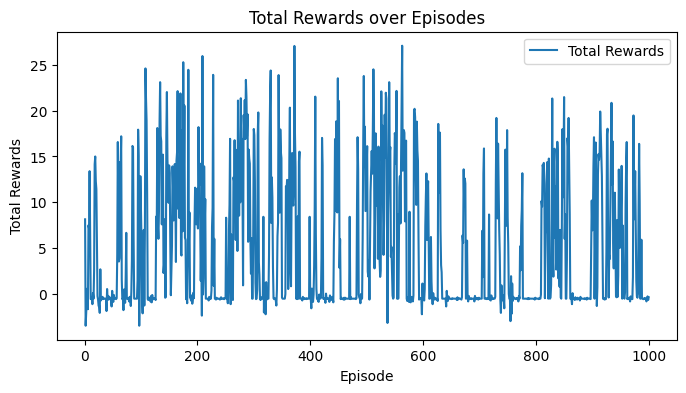

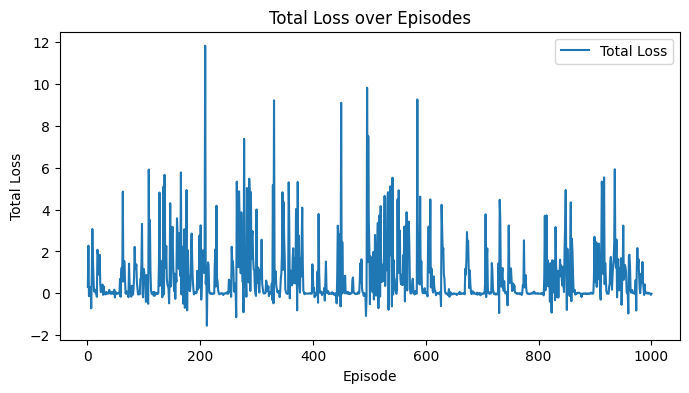

In [13]:
import matplotlib.pyplot as plt

# Plot Total Rewards
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_rewards_list, label='Total Rewards')
plt.title('Total Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()



# Plot Total Loss
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_loss_list, label='Total Loss')
plt.title('Total Loss over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.legend()
plt.show()


Training again after making changes to some hyperparameters

In [9]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
from argparse import Namespace
import multiprocessing as _mp
import shutil
import tensorflow as tf
import warnings
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_args():
    args = Namespace(
        action_type="COMPLEX_MOVEMENT",
        lr=0.00025,
        gamma=0.95,
        tau=1.0,
        beta=0.01,
        num_local_steps=50,
        num_processes=2,
        save_interval=250,
        # max_actions=200,
        log_path="tensorboard/a3c_super_mario_bros",
        saved_path="trained_models",
        load_from_previous_stage=False,
        num_epochs= 10,
        batch_size = 10,
        epsilon = 0.3,
        output_path = "output"
    )
    return args


In [10]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
consecutive_perfect_rewards = 0
consecutive_episodes_to_stop = 10
episode_list = []
total_steps_list = []
total_rewards_list = []
mean_rewards_list = []
total_loss_list = []

def train(opt, total_ep):
    print("INITIALIZING")
    tf.random.set_seed(123)
    print("SEED SET")
    if os.path.isdir(opt.log_path):
        shutil.rmtree(opt.log_path)
    os.makedirs(opt.log_path)
    if not os.path.isdir(opt.saved_path):
        os.makedirs(opt.saved_path)

    envs = create_train_env(actions=COMPLEX_MOVEMENT)
    print("ENV DONE")
    model = PPO(num_inputs=envs.observation_space.shape, num_actions=envs.action_space.n)
    print("PPO SET")
    model.build((None,) + envs.observation_space.shape)
    print("PPO BUILD")

    optimizer = tf.keras.optimizers.Adam(learning_rate=opt.lr)
    curr_states = envs.reset()

    curr_episode = 0
    print("Done initializing")
    while curr_episode < total_ep:
        curr_episode += 1
        total_steps = 0
        old_log_policies = []
        actions = []
        values = []
        states = []
        rewards = []
        dones = []
        if curr_episode % opt.batch_size == 0:
            model.save("{}/ppo_super_mario_bros".format(opt.saved_path), signatures=None)
        if curr_episode % opt.save_interval == 0 and curr_episode > 0:
            model.save("{}/ppo_super_mario_bros".format(opt.saved_path), signatures=None)

        for _ in range(opt.num_local_steps):
            total_steps +=1
            states.append(curr_states)
            logits, value = model(curr_states)
            values.append(tf.squeeze(value))
            policy = tf.nn.softmax(logits, axis=1)
            old_m = tfp.distributions.Categorical(probs=policy)
            action = old_m.sample()
            actions.append(action)
            old_log_policy = old_m.log_prob(action)
            old_log_policies.append(old_log_policy)

            state, reward, done, info = envs.step(action.numpy().item())
            rewards.append(reward)
            dones.append(done)
            curr_states = state

        _, next_value = model(curr_states)
        next_value = tf.squeeze(next_value)
        old_log_policies = tf.concat(old_log_policies, axis=0)
        actions = tf.concat(actions, axis=0)
        values = tf.concat(values, axis=0)
        states = tf.concat(states, axis=0)

        
        gae = 0
        R = []

        # Calculate advantages and accumulate returns
        for value, reward, done in list(zip(values, rewards, dones))[::-1]:
            gae = gae * opt.gamma * opt.tau
            gae = gae + reward + opt.gamma * next_value * (1 - done) - value
            next_value = value
            R.append(gae + value)

        R = R[::-1]
        R = tf.concat(R, axis=0)
        advantages = R - values

        # PPO update loop
        for i in range(opt.num_epochs):
            indices = tf.random.shuffle(tf.range(opt.num_local_steps * opt.num_processes))
            for j in range(opt.batch_size):
                batch_indices = indices[
                    int(j * (opt.num_local_steps * opt.num_processes / opt.batch_size)): int((j + 1) * (
                            opt.num_local_steps * opt.num_processes / opt.batch_size))]

                # Gather states, actions, and old log policies using batch_indices
                batch_indices = tf.cast(batch_indices, dtype=tf.int32) #!
                batch_states = tf.gather(states, batch_indices)
                batch_actions = tf.gather(actions, batch_indices)
                batch_old_log_policies = tf.gather(old_log_policies, batch_indices)

                # Forward pass through the model
                with tf.GradientTape() as tape:
                    logits, value = model(batch_states)
                    new_policy = tf.nn.softmax(logits, axis=1)
                    new_m = tfp.distributions.Categorical(probs=new_policy)
                    new_log_policy = new_m.log_prob(batch_actions)

                    # PPO loss calculation
                    ratio = tf.exp(new_log_policy - batch_old_log_policies)
                    actor_loss = -tf.reduce_mean(tf.minimum(
                        ratio * tf.gather(advantages, batch_indices),
                        tf.clip_by_value(ratio, 1.0 - opt.epsilon, 1.0 + opt.epsilon) * tf.gather(advantages, batch_indices)
                    ))
                    R = tf.cast(R, dtype=tf.float32)
                    value = tf.cast(value, dtype=tf.float32)

                    critic_loss = tf.reduce_mean(tf.losses.mean_squared_error(R, value))
                    entropy_loss = tf.reduce_mean(new_m.entropy())
                    total_loss = actor_loss + critic_loss - opt.beta * entropy_loss

                # Optimization step
                gradients = tape.gradient(total_loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 0.5)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Calculate metrics
        episode_list.append(curr_episode)
        total_steps_list.append(total_steps)
        total_rewards_list.append(sum(rewards))
        total_loss_list.append(total_loss)

        print("Episode: {}. Total Steps: {}. Total Rewards: {}. Total Loss: {}".format(
        curr_episode,
        total_steps,
        sum(rewards),
        total_loss
    ))
         # Check if the agent achieved a perfect reward
        if sum(rewards) == 100:
            consecutive_perfect_rewards += 1
        else:
            consecutive_perfect_rewards = 0
        # Check if the stopping criterion is met
        if consecutive_perfect_rewards >= consecutive_episodes_to_stop:
            print(f"Training stopped after {consecutive_episodes_to_stop} consecutive perfect rewards.")
            break


if __name__ == "__main__":
    opt = get_args()
    train(opt,total_ep=1000)

INITIALIZING
SEED SET


c:\Users\sudha\py10\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-1-1-v3`.
  logger.warn(


ENV DONE
PPO SET
PPO BUILD
Done initializing
Episode: 1. Total Steps: 50. Total Rewards: 8.15. Total Loss: 1.1333929300308228
Episode: 2. Total Steps: 50. Total Rewards: 0.9249999999999996. Total Loss: 2.4985122680664062
Episode: 3. Total Steps: 50. Total Rewards: 9.249999999999998. Total Loss: 0.9829548597335815
Episode: 4. Total Steps: 50. Total Rewards: 0.10000000000000017. Total Loss: 1.1251697540283203
Episode: 5. Total Steps: 50. Total Rewards: 6.8500000000000005. Total Loss: 0.33393412828445435
Episode: 6. Total Steps: 50. Total Rewards: -0.7. Total Loss: 0.6170713901519775
Episode: 7. Total Steps: 50. Total Rewards: -4.2. Total Loss: 1.437262773513794
Episode: 8. Total Steps: 50. Total Rewards: 3.4000000000000004. Total Loss: -0.059319354593753815
Episode: 9. Total Steps: 50. Total Rewards: -2.3. Total Loss: 0.8457434177398682


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 10. Total Steps: 50. Total Rewards: -0.8500000000000005. Total Loss: 0.7217715978622437
Episode: 11. Total Steps: 50. Total Rewards: -2.25. Total Loss: 0.2668316662311554
Episode: 12. Total Steps: 50. Total Rewards: 3.4500000000000006. Total Loss: 0.48047497868537903
Episode: 13. Total Steps: 50. Total Rewards: -0.7000000000000004. Total Loss: 0.5025492310523987
Episode: 14. Total Steps: 50. Total Rewards: -1.4499999999999988. Total Loss: 0.5634135603904724
Episode: 15. Total Steps: 50. Total Rewards: -0.049999999999999156. Total Loss: 1.0251538753509521
Episode: 16. Total Steps: 50. Total Rewards: 0.9000000000000001. Total Loss: 0.1259671449661255
Episode: 17. Total Steps: 50. Total Rewards: 5.200000000000001. Total Loss: 0.4983428120613098
Episode: 18. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.36089619994163513
Episode: 19. Total Steps: 50. Total Rewards: -1.0999999999999999. Total Loss: 0.4528251886367798


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 20. Total Steps: 50. Total Rewards: 6.938893903907228e-17. Total Loss: 0.011443495750427246
Episode: 21. Total Steps: 50. Total Rewards: -0.8999999999999999. Total Loss: 0.026070574298501015
Episode: 22. Total Steps: 50. Total Rewards: -2.0499999999999994. Total Loss: 1.2288613319396973
Episode: 23. Total Steps: 50. Total Rewards: 1.5499999999999998. Total Loss: -0.05598645657300949
Episode: 24. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: -0.06006934121251106
Episode: 25. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.006246600300073624
Episode: 26. Total Steps: 50. Total Rewards: -0.5000000000000002. Total Loss: -0.04502635821700096
Episode: 27. Total Steps: 50. Total Rewards: -0.5500000000000002. Total Loss: -0.01809060573577881
Episode: 28. Total Steps: 50. Total Rewards: -0.45000000000000034. Total Loss: -0.0872403159737587
Episode: 29. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: -0.00796863529831171


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 30. Total Steps: 50. Total Rewards: -1.2. Total Loss: 0.9433436393737793
Episode: 31. Total Steps: 50. Total Rewards: 0.2. Total Loss: 0.03541359305381775
Episode: 32. Total Steps: 50. Total Rewards: -0.4999999999999999. Total Loss: 0.023727720603346825
Episode: 33. Total Steps: 50. Total Rewards: -0.5. Total Loss: -0.006161447614431381
Episode: 34. Total Steps: 50. Total Rewards: -0.49999999999999956. Total Loss: 0.4202960431575775
Episode: 35. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.00709361769258976
Episode: 36. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.017061419785022736
Episode: 37. Total Steps: 50. Total Rewards: -1.8500000000000005. Total Loss: 0.36521175503730774
Episode: 38. Total Steps: 50. Total Rewards: 0.75. Total Loss: 0.19703960418701172
Episode: 39. Total Steps: 50. Total Rewards: -0.5499999999999999. Total Loss: -0.13575346767902374


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 40. Total Steps: 50. Total Rewards: -0.5000000000000001. Total Loss: 0.03953075781464577
Episode: 41. Total Steps: 50. Total Rewards: 10.775. Total Loss: 1.9090583324432373
Episode: 42. Total Steps: 50. Total Rewards: 12.849999999999994. Total Loss: 5.066258430480957
Episode: 43. Total Steps: 50. Total Rewards: -0.45000000000000007. Total Loss: 3.129906415939331
Episode: 44. Total Steps: 50. Total Rewards: -0.49999999999999956. Total Loss: 0.8487929701805115
Episode: 45. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.3247406482696533
Episode: 46. Total Steps: 50. Total Rewards: 3.65. Total Loss: -0.24861522018909454
Episode: 47. Total Steps: 50. Total Rewards: 17.675. Total Loss: -2.912802219390869
Episode: 48. Total Steps: 50. Total Rewards: 6.8999999999999995. Total Loss: 3.15282940864563
Episode: 49. Total Steps: 50. Total Rewards: -0.5000000000000002. Total Loss: 2.2576115131378174


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 50. Total Steps: 50. Total Rewards: 0.5000000000000001. Total Loss: 0.5004342198371887
Episode: 51. Total Steps: 50. Total Rewards: 4.725000000000001. Total Loss: 1.2976962327957153
Episode: 52. Total Steps: 50. Total Rewards: -0.19999999999999996. Total Loss: 0.29125142097473145
Episode: 53. Total Steps: 50. Total Rewards: -3.3. Total Loss: 1.905313491821289
Episode: 54. Total Steps: 50. Total Rewards: -0.40000000000000024. Total Loss: 0.49248525500297546
Episode: 55. Total Steps: 50. Total Rewards: -1.3499999999999996. Total Loss: 0.15227872133255005
Episode: 56. Total Steps: 50. Total Rewards: 0.7000000000000002. Total Loss: 0.6134235262870789
Episode: 57. Total Steps: 50. Total Rewards: 1.9000000000000006. Total Loss: 0.3498043119907379
Episode: 58. Total Steps: 50. Total Rewards: 7.9999999999999964. Total Loss: 0.24836577475070953
Episode: 59. Total Steps: 50. Total Rewards: 10.524999999999999. Total Loss: -0.3915998935699463


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 60. Total Steps: 50. Total Rewards: 10.899999999999997. Total Loss: 1.4646626710891724
Episode: 61. Total Steps: 50. Total Rewards: 9.799999999999995. Total Loss: 0.9567780494689941
Episode: 62. Total Steps: 50. Total Rewards: 12.55. Total Loss: 0.7993187308311462
Episode: 63. Total Steps: 50. Total Rewards: 19.20000000000001. Total Loss: 0.028807558119297028
Episode: 64. Total Steps: 50. Total Rewards: 15.499999999999996. Total Loss: 10.943524360656738
Episode: 65. Total Steps: 50. Total Rewards: 9.849999999999998. Total Loss: 8.292673110961914
Episode: 66. Total Steps: 50. Total Rewards: 11.025. Total Loss: 0.20610901713371277
Episode: 67. Total Steps: 50. Total Rewards: 12.499999999999998. Total Loss: 0.14654555916786194
Episode: 68. Total Steps: 50. Total Rewards: 6.424999999999998. Total Loss: 2.3815720081329346
Episode: 69. Total Steps: 50. Total Rewards: 9.599999999999998. Total Loss: 1.2490460872650146


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 70. Total Steps: 50. Total Rewards: 4.2. Total Loss: 8.601621627807617
Episode: 71. Total Steps: 50. Total Rewards: 11.749999999999996. Total Loss: 0.9152740240097046
Episode: 72. Total Steps: 50. Total Rewards: 12.45. Total Loss: 1.7830389738082886
Episode: 73. Total Steps: 50. Total Rewards: 7.599999999999999. Total Loss: 1.5251867771148682
Episode: 74. Total Steps: 50. Total Rewards: -0.4999999999999999. Total Loss: 1.3577579259872437
Episode: 75. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.35115253925323486
Episode: 76. Total Steps: 50. Total Rewards: -0.65. Total Loss: 0.1465405523777008
Episode: 77. Total Steps: 50. Total Rewards: -0.3500000000000001. Total Loss: 0.011889886111021042
Episode: 78. Total Steps: 50. Total Rewards: -0.39999999999999986. Total Loss: -0.10764185339212418
Episode: 79. Total Steps: 50. Total Rewards: -1.2500000000000004. Total Loss: 0.8929123282432556


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 80. Total Steps: 50. Total Rewards: 0.15. Total Loss: -0.1621474176645279
Episode: 81. Total Steps: 50. Total Rewards: 2.0. Total Loss: -0.26567620038986206
Episode: 82. Total Steps: 50. Total Rewards: 15.274999999999999. Total Loss: -0.31858521699905396
Episode: 83. Total Steps: 50. Total Rewards: 10.099999999999998. Total Loss: 0.6019670367240906
Episode: 84. Total Steps: 50. Total Rewards: 8.55. Total Loss: 3.950965404510498
Episode: 85. Total Steps: 50. Total Rewards: 6.0249999999999995. Total Loss: 1.579062819480896
Episode: 86. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.580570638179779
Episode: 87. Total Steps: 50. Total Rewards: -0.49999999999999983. Total Loss: 0.07007544487714767
Episode: 88. Total Steps: 50. Total Rewards: -0.5000000000000002. Total Loss: 0.09265966713428497
Episode: 89. Total Steps: 50. Total Rewards: -3.1500000000000012. Total Loss: 1.8750996589660645


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 90. Total Steps: 50. Total Rewards: -0.20000000000000026. Total Loss: -0.31262823939323425
Episode: 91. Total Steps: 50. Total Rewards: 1.8499999999999996. Total Loss: 0.006121756508946419
Episode: 92. Total Steps: 50. Total Rewards: -0.65. Total Loss: 0.0572839193046093
Episode: 93. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.08918225765228271
Episode: 94. Total Steps: 50. Total Rewards: -2.4. Total Loss: 0.4966602325439453
Episode: 95. Total Steps: 50. Total Rewards: 1.55. Total Loss: 0.1506747007369995
Episode: 96. Total Steps: 50. Total Rewards: -0.5000000000000001. Total Loss: 0.0700121819972992
Episode: 97. Total Steps: 50. Total Rewards: -0.4999999999999999. Total Loss: 0.04454422742128372
Episode: 98. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.011467058211565018
Episode: 99. Total Steps: 50. Total Rewards: -0.5499999999999999. Total Loss: 0.003110138699412346


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 100. Total Steps: 50. Total Rewards: -0.4500000000000002. Total Loss: 0.04753056913614273
Episode: 101. Total Steps: 50. Total Rewards: -0.5000000000000001. Total Loss: -0.0006013792008161545
Episode: 102. Total Steps: 50. Total Rewards: 3.7499999999999996. Total Loss: 1.1910479068756104
Episode: 103. Total Steps: 50. Total Rewards: 11.599999999999994. Total Loss: -0.03333154320716858
Episode: 104. Total Steps: 50. Total Rewards: 12.049999999999997. Total Loss: 3.788297414779663
Episode: 105. Total Steps: 50. Total Rewards: 15.825000000000001. Total Loss: -0.42155715823173523
Episode: 106. Total Steps: 50. Total Rewards: 0.5999999999999994. Total Loss: 3.0007050037384033
Episode: 107. Total Steps: 50. Total Rewards: 5.85. Total Loss: 0.8544430136680603
Episode: 108. Total Steps: 50. Total Rewards: 8.724999999999998. Total Loss: 0.9409835338592529
Episode: 109. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: 0.6336817145347595


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 110. Total Steps: 50. Total Rewards: 8.149999999999999. Total Loss: -0.5864456295967102
Episode: 111. Total Steps: 50. Total Rewards: 10.399999999999997. Total Loss: 4.260120868682861
Episode: 112. Total Steps: 50. Total Rewards: 15.849999999999996. Total Loss: -0.34966418147087097
Episode: 113. Total Steps: 50. Total Rewards: 7.099999999999998. Total Loss: 10.661725997924805
Episode: 114. Total Steps: 50. Total Rewards: 10.749999999999998. Total Loss: 4.16447114944458
Episode: 115. Total Steps: 50. Total Rewards: 18.125000000000007. Total Loss: 0.43857541680336
Episode: 116. Total Steps: 50. Total Rewards: 15.224999999999994. Total Loss: 0.4826492369174957
Episode: 117. Total Steps: 50. Total Rewards: 16.200000000000003. Total Loss: 0.356062650680542
Episode: 118. Total Steps: 50. Total Rewards: 12.274999999999993. Total Loss: 10.618948936462402
Episode: 119. Total Steps: 50. Total Rewards: 17.275000000000002. Total Loss: -0.10823029279708862


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 120. Total Steps: 50. Total Rewards: 14.075. Total Loss: 2.97586989402771
Episode: 121. Total Steps: 50. Total Rewards: 0.15000000000000005. Total Loss: 4.254856109619141
Episode: 122. Total Steps: 50. Total Rewards: 7.7250000000000005. Total Loss: 2.05133318901062
Episode: 123. Total Steps: 50. Total Rewards: -0.4499999999999999. Total Loss: 1.8306618928909302
Episode: 124. Total Steps: 50. Total Rewards: -1.2500000000000002. Total Loss: 0.26510903239250183
Episode: 125. Total Steps: 50. Total Rewards: -2.75. Total Loss: 0.9107440114021301
Episode: 126. Total Steps: 50. Total Rewards: -0.19999999999999996. Total Loss: 0.21026915311813354
Episode: 127. Total Steps: 50. Total Rewards: 9.05. Total Loss: 2.4120395183563232
Episode: 128. Total Steps: 50. Total Rewards: -3.15. Total Loss: 8.800198554992676
Episode: 129. Total Steps: 50. Total Rewards: 4.05. Total Loss: 1.1546313762664795


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 130. Total Steps: 50. Total Rewards: 6.350000000000001. Total Loss: 3.3938355445861816
Episode: 131. Total Steps: 50. Total Rewards: 12.9. Total Loss: -1.1560792922973633
Episode: 132. Total Steps: 50. Total Rewards: 11.500000000000002. Total Loss: 0.5192952752113342
Episode: 133. Total Steps: 50. Total Rewards: 5.95. Total Loss: 7.874245643615723
Episode: 134. Total Steps: 50. Total Rewards: 9.65. Total Loss: 1.3560174703598022
Episode: 135. Total Steps: 50. Total Rewards: 4.699999999999997. Total Loss: 1.2722398042678833
Episode: 136. Total Steps: 50. Total Rewards: 2.7500000000000004. Total Loss: 0.9283133149147034
Episode: 137. Total Steps: 50. Total Rewards: 2.9499999999999993. Total Loss: 0.1290350705385208
Episode: 138. Total Steps: 50. Total Rewards: 0.85. Total Loss: 0.2106509506702423
Episode: 139. Total Steps: 50. Total Rewards: -1.05. Total Loss: 0.18594424426555634


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 140. Total Steps: 50. Total Rewards: -3.799999999999999. Total Loss: 1.469858169555664
Episode: 141. Total Steps: 50. Total Rewards: 0.10000000000000019. Total Loss: 0.2476368397474289
Episode: 142. Total Steps: 50. Total Rewards: -0.9500000000000002. Total Loss: -0.0706930011510849
Episode: 143. Total Steps: 50. Total Rewards: 2.5500000000000003. Total Loss: 0.2966866195201874
Episode: 144. Total Steps: 50. Total Rewards: 0.20000000000000007. Total Loss: 0.3167506754398346
Episode: 145. Total Steps: 50. Total Rewards: 5.499999999999999. Total Loss: 0.7135456800460815
Episode: 146. Total Steps: 50. Total Rewards: 4.3. Total Loss: 2.7175309658050537
Episode: 147. Total Steps: 50. Total Rewards: 9.299999999999999. Total Loss: -0.11778624355792999
Episode: 148. Total Steps: 50. Total Rewards: 9.100000000000001. Total Loss: 0.49113088846206665
Episode: 149. Total Steps: 50. Total Rewards: 7.95. Total Loss: 1.1879101991653442


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 150. Total Steps: 50. Total Rewards: 5.325. Total Loss: 1.5310499668121338
Episode: 151. Total Steps: 50. Total Rewards: -0.5499999999999998. Total Loss: 0.9293633699417114
Episode: 152. Total Steps: 50. Total Rewards: -0.6500000000000002. Total Loss: 0.22859454154968262
Episode: 153. Total Steps: 50. Total Rewards: -0.4500000000000002. Total Loss: 0.09291893988847733
Episode: 154. Total Steps: 50. Total Rewards: -0.5500000000000002. Total Loss: 0.07948069274425507
Episode: 155. Total Steps: 50. Total Rewards: -0.3000000000000003. Total Loss: 0.11574625968933105
Episode: 156. Total Steps: 50. Total Rewards: -0.49999999999999994. Total Loss: -0.03082452155649662
Episode: 157. Total Steps: 50. Total Rewards: -0.5000000000000001. Total Loss: -0.044278860092163086
Episode: 158. Total Steps: 50. Total Rewards: -0.49999999999999983. Total Loss: 0.010485969483852386
Episode: 159. Total Steps: 50. Total Rewards: -0.5. Total Loss: -0.013634426519274712


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 160. Total Steps: 50. Total Rewards: -0.85. Total Loss: 0.015643851831555367
Episode: 161. Total Steps: 50. Total Rewards: 3.0. Total Loss: -0.1533244550228119
Episode: 162. Total Steps: 50. Total Rewards: 5.524999999999999. Total Loss: 1.5627405643463135
Episode: 163. Total Steps: 50. Total Rewards: 5.999999999999999. Total Loss: 0.5748599767684937
Episode: 164. Total Steps: 50. Total Rewards: 9.749999999999998. Total Loss: 3.0948240756988525
Episode: 165. Total Steps: 50. Total Rewards: 13.350000000000003. Total Loss: 0.4346645772457123
Episode: 166. Total Steps: 50. Total Rewards: 4.95. Total Loss: 2.0017402172088623
Episode: 167. Total Steps: 50. Total Rewards: 6.074999999999998. Total Loss: 0.6042707562446594
Episode: 168. Total Steps: 50. Total Rewards: 1.3. Total Loss: 1.6344637870788574
Episode: 169. Total Steps: 50. Total Rewards: 6.199999999999999. Total Loss: 1.6433897018432617


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 170. Total Steps: 50. Total Rewards: 11.0. Total Loss: 0.2543905973434448
Episode: 171. Total Steps: 50. Total Rewards: 6.8. Total Loss: 7.349147319793701
Episode: 172. Total Steps: 50. Total Rewards: 10.399999999999997. Total Loss: 3.0042977333068848
Episode: 173. Total Steps: 50. Total Rewards: 15.024999999999997. Total Loss: -0.6216533184051514
Episode: 174. Total Steps: 50. Total Rewards: 9.299999999999997. Total Loss: 1.00444495677948
Episode: 175. Total Steps: 50. Total Rewards: 6.0249999999999995. Total Loss: 0.8758634924888611
Episode: 176. Total Steps: 50. Total Rewards: 8.674999999999997. Total Loss: 0.7420876622200012
Episode: 177. Total Steps: 50. Total Rewards: -0.5000000000000001. Total Loss: 2.2188150882720947
Episode: 178. Total Steps: 50. Total Rewards: -3.2. Total Loss: 1.138280987739563
Episode: 179. Total Steps: 50. Total Rewards: 2.200000000000001. Total Loss: -0.029640745371580124


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 180. Total Steps: 50. Total Rewards: -1.4. Total Loss: 0.13552530109882355
Episode: 181. Total Steps: 50. Total Rewards: -0.4. Total Loss: 0.22357390820980072
Episode: 182. Total Steps: 50. Total Rewards: -1.4500000000000004. Total Loss: 0.36806219816207886
Episode: 183. Total Steps: 50. Total Rewards: 1.1500000000000004. Total Loss: -0.3634670674800873
Episode: 184. Total Steps: 50. Total Rewards: -0.4500000000000001. Total Loss: -0.05763913691043854
Episode: 185. Total Steps: 50. Total Rewards: 0.85. Total Loss: -0.2825956344604492
Episode: 186. Total Steps: 50. Total Rewards: 21.90000000000001. Total Loss: 1.4734416007995605
Episode: 187. Total Steps: 50. Total Rewards: 15.5. Total Loss: 12.45804500579834
Episode: 188. Total Steps: 50. Total Rewards: 12.349999999999994. Total Loss: 8.464415550231934
Episode: 189. Total Steps: 50. Total Rewards: 14.424999999999997. Total Loss: 0.6159855723381042


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


Episode: 190. Total Steps: 50. Total Rewards: 8.299999999999999. Total Loss: 1.1353721618652344
Episode: 191. Total Steps: 50. Total Rewards: 6.075000000000001. Total Loss: 1.443314552307129
Episode: 192. Total Steps: 50. Total Rewards: 2.500000000000001. Total Loss: 0.949594259262085
Episode: 193. Total Steps: 50. Total Rewards: -0.14999999999999994. Total Loss: 0.2328500747680664
Episode: 194. Total Steps: 50. Total Rewards: -0.4499999999999998. Total Loss: 0.11800214648246765
Episode: 195. Total Steps: 50. Total Rewards: -0.5. Total Loss: 0.06074061244726181
Episode: 196. Total Steps: 50. Total Rewards: 7.000000000000001. Total Loss: -0.22104589641094208
Episode: 197. Total Steps: 50. Total Rewards: 3.5500000000000007. Total Loss: 0.9744299054145813
Episode: 198. Total Steps: 50. Total Rewards: 5.3. Total Loss: 2.921257257461548
Episode: 199. Total Steps: 50. Total Rewards: -1.6000000000000003. Total Loss: 0.43524330854415894


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


INFO:tensorflow:Assets written to: trained_models/ppo_super_mario_bros\assets


: 

In [ ]:
import matplotlib.pyplot as plt

# Plot Total Rewards
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_rewards_list, label='Total Rewards')
plt.title('Total Rewards over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()



# Plot Total Loss
plt.figure(figsize=(8, 4))
plt.plot(episode_list, total_loss_list, label='Total Loss')
plt.title('Total Loss over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Loss')
plt.legend()
plt.show()


TEST 

In [ ]:
# def test(opt):
#     tf.random.set_seed(123)
#     if opt.action_type == "right":
#         actions = RIGHT_ONLY
#     elif opt.action_type == "simple":
#         actions = SIMPLE_MOVEMENT
#     else:
#         actions = COMPLEX_MOVEMENT
#     env = create_train_env(actions,
#                             "{}/video.mp4".format(opt.output_path))
    
#     model = PPO(num_inputs=env.observation_space.shape, num_actions=env.action_space.n)
#     model.build((None,) + env.observation_space.shape)

#     model.load_weights(f"{opt.saved_path}/ppo_super_mario_bros")

#     state = np.expand_dims(env.reset(), axis=0)
#     while True:
#         logits, value = model(state)
#         policy = tf.nn.softmax(logits, axis=1)
#         action = tf.argmax(policy, axis=1).numpy().item()
#         state, reward, done, info = env.step(action)
#         state = np.expand_dims(state, axis=0)
#         env.render()
#         if info["flag_get"]:
#             print(f"completed")
#             break

# if __name__ == "__main__":
#     opt = get_args()
#     test(opt)

In [ ]:
# import numpy as np
# import tensorflow as tf
# from argparse import Namespace
# from gym_super_mario_bros.actions import COMPLEX_MOVEMENT

# def test(opt):
#     tf.random.set_seed(123)
    
#     # Set the appropriate actions based on your training configuration
#     actions = COMPLEX_MOVEMENT
    
#     # Create the test environment without video recording
#     env = create_train_env(actions)
    
#     # Create the PPO model
#     model = PPO(num_inputs=env.observation_space.shape, num_actions=env.action_space.n)
#     model.build((None,) + env.observation_space.shape)

#     # Load the trained weights
#     model.load_weights(f"{opt.saved_path}/ppo_super_mario_bros")

#     state = np.expand_dims(env.reset(), axis=0)
#     while True:
#         logits, value = model(state)
#         policy = tf.nn.softmax(logits, axis=1)
#         action = tf.argmax(policy, axis=1).numpy().item()
#         state, reward, done, info = env.step(action)
#         state = np.expand_dims(state, axis=0)
#         env.render()
#         if done:
#             break

# if __name__ == "__main__":
#     opt = Namespace(
#         action_type="COMPLEX_MOVEMENT",
#         lr=0.001,
#         gamma=0.9,
#         tau=1.0,
#         beta=0.01,
#         num_local_steps=50,
#         num_processes=2,
#         save_interval=250,
#         log_path="tensorboard/a3c_super_mario_bros",
#         saved_path="trained_models",
#         load_from_previous_stage=False,
#         num_epochs=10,
#         batch_size=16,
#         epsilon=0.2,
#         output_path="output"
#     )
#     test(opt)


NameError: name 'create_train_env' is not defined